In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyg_lib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torch_geometric.transforms import RandomNodeSplit
data = torch.load('data/directed_graph.pt', weights_only=False)
node_transform = RandomNodeSplit(num_val=0.2, num_test=0)
node_splits = node_transform(data)

In [3]:
from models.GNN import MutliTaskGNN

model = MutliTaskGNN(diseases=['AD', 'PD'],
                     in_channels=data.x.shape[1], 
                     hidden_channels=8,
                     n_gcn_layers=1,
                     shared_channels=128,
                     dropout = 0.5
                     )
model

MutliTaskGNN(
  (encoders): ModuleDict(
    (AD): GAT(51, 8, num_layers=1)
    (PD): GAT(51, 8, num_layers=1)
  )
  (shared_layer): Linear(in_features=16, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sig_head): ModuleDict(
    (AD): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
    (PD): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (role_head): ModuleDict(
    (AD): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=2, bias=True)
    )
    (PD): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (abundance_head): ModuleDict(


In [4]:
def compute_loss(out, target, mask=[]):
    sig_loss = torch.nn.CrossEntropyLoss()(out['sig'][mask], target['sig'][mask].float())
    role_loss = torch.nn.CrossEntropyLoss()(out['role'][mask], target['role'][mask].long().argmax(dim=1))
    abundance_loss = torch.nn.MSELoss()(out['abundance'][mask], target['abundance'][mask])
    return sig_loss, role_loss, abundance_loss

In [10]:
from tqdm import trange
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

epochs = 50
model.train()
train_loss_list = []
valid_loss_list = []

pbar = trange(epochs, desc='Epochs')
data = data.to(device)
for epoch in pbar:
    model.train()
    train_loss = np.zeros(3)
    for disease in model.diseases:
        optimizer.zero_grad()
        out = model(data.x, 
                    data.edge_index, 
                    disease, 
                    data.edge_weight)
        
        sig_loss, role_loss, abundance_loss = compute_loss(out, data.y[disease], mask=node_splits.val_mask)
        loss = sig_loss + role_loss + abundance_loss
        
        loss.backward()
        optimizer.step()
        train_loss = train_loss + np.array([sig_loss.item(), role_loss.item(), abundance_loss.item()])

    model.eval()
    valid_loss = np.zeros(3)
    with torch.no_grad():
        for disease in model.diseases:
            out = model(data.x, 
                        data.edge_index, 
                        disease, 
                        data.edge_weight)
                        
            sig_loss, role_loss, abundance_loss  = compute_loss(out, data.y[disease], mask=node_splits.val_mask)
            valid_loss = valid_loss + np.array([sig_loss.item(), role_loss.item(), abundance_loss.item()])

    train_loss /= len(model.diseases)
    valid_loss /= len(model.diseases)

    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    pbar.set_postfix({
        'Epoch': f'{epoch+1}/{epochs}',
        'Train Loss': f'{np.sum(train_loss):.4f}',
        'Valid Loss': f'{np.sum(valid_loss):.4f}'
    })

Epochs: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it, Epoch=50/50, Train Loss=0.1086, Valid Loss=0.0991]


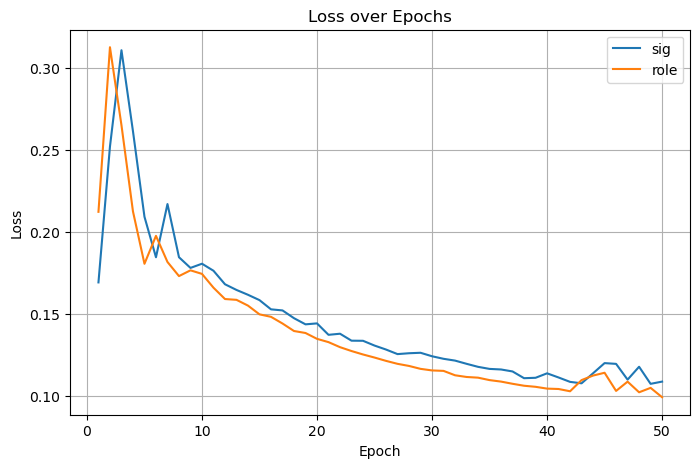

In [22]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), np.array(train_loss_list).sum(axis=1), label='sig')
plt.plot(range(1, epochs+1), np.array(valid_loss_list).sum(axis=1), label='role')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

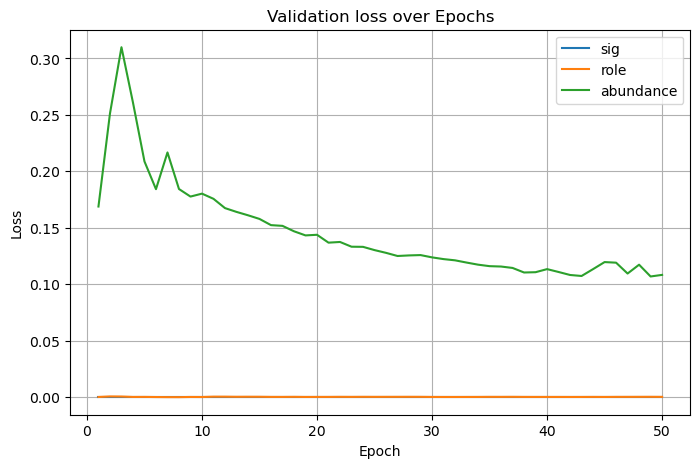

In [18]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), np.array(train_loss_list)[:, 0], label='sig')
plt.plot(range(1, epochs+1), np.array(train_loss_list)[:, 1], label='role')
plt.plot(range(1, epochs+1), np.array(train_loss_list)[:, 2], label='abundance')
plt.title("Validation loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

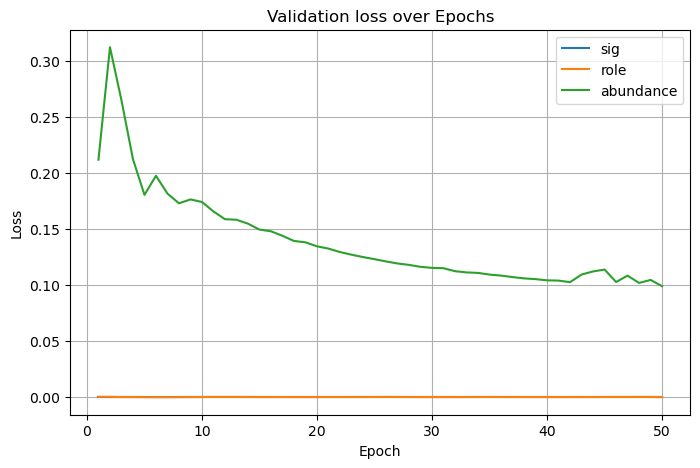

In [20]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), np.array(valid_loss_list)[:, 0], label='sig')
plt.plot(range(1, epochs+1), np.array(valid_loss_list)[:, 1], label='role')
plt.plot(range(1, epochs+1), np.array(valid_loss_list)[:, 2], label='abundance')
plt.title("Validation loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)